In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.datasets import make_moons

## Data preprocessing

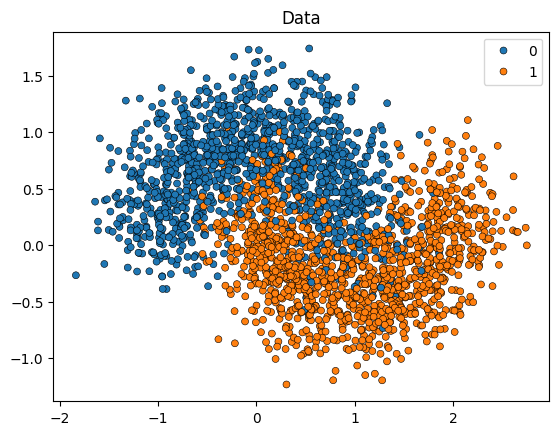

In [2]:
points, labels = make_moons(n_samples=2500, shuffle=True, noise=0.3, random_state=0)

sns.scatterplot(
    x=points[:, 0], y=points[:, 1], hue=labels, marker="o", s=25, edgecolor="k", legend=True
).set_title("Data")
plt.show()

### Train / Validation / Test split

In [3]:
from sklearn.model_selection import train_test_split

# split 70/30
X_train, X_test, y_train, y_test = train_test_split(points, labels, test_size=0.3, random_state=2)
# X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=2)

In [4]:
X_train.shape, X_test.shape

((1750, 2), (750, 2))

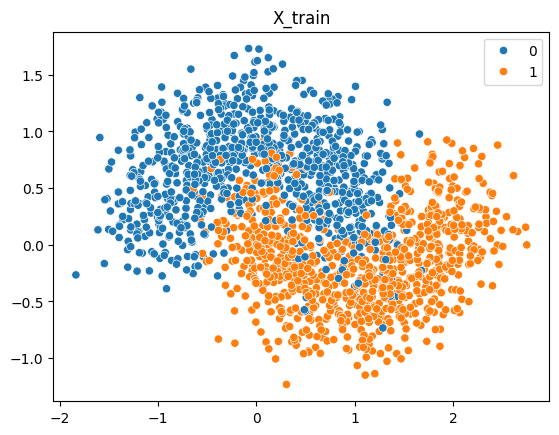

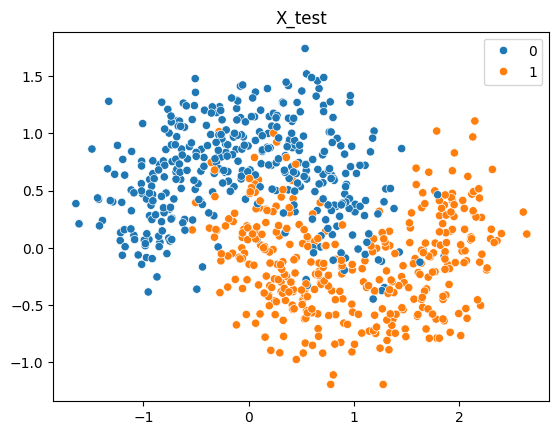

In [5]:
sns.scatterplot(
    x=X_train[:, 0], y=X_train[:, 1], hue=y_train, marker='o'
).set_title('X_train')
plt.show()

# sns.scatterplot(
#     x=X_valid[:, 0], y=X_valid[:, 1], hue=y_valid, marker='o'
# ).set_title('X_valid')
# plt.show()

sns.scatterplot(
    x=X_test[:, 0], y=X_test[:, 1], hue=y_test, marker='o'
).set_title('X_test')
plt.show()

### Converting to PyTorch Tensor

In [6]:
X_train = torch.from_numpy(X_train).to(dtype=torch.float32)
# X_valid = torch.from_numpy(X_valid).to(dtype=torch.float32)
X_test = torch.from_numpy(X_test).to(dtype=torch.float32)

y_train = torch.from_numpy(y_train).to(dtype=torch.float32)
# y_valid = torch.from_numpy(y_valid).to(dtype=torch.float32)
y_test = torch.from_numpy(y_test).to(dtype=torch.float32)

### Data without split

In [7]:
# X = torch.from_numpy(points).to(dtype=torch.float32)
# y = torch.from_numpy(labels).to(dtype=torch.float32)

## Setting up the device for training

In [8]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## 1. Creating CustomDataset class

In [9]:
class CustomDataset(Dataset):
    def __init__(self, features, target, file_path=''):
        if file_path:
            self.dataset = pd.read_csv(file_path)
            self.target = self.dataset[target].to_numpy()
            self.features = self.dataset[features].to_numpy()
        else:
            self.dataset = None
            self.target = np.array(target).flatten()
            self.features = np.array(features)
        # Converting to PyTorch Tensor
        self.target = torch.from_numpy(self.target).to(dtype=torch.float32)
        self.features = torch.from_numpy(self.features).to(dtype=torch.float32)

    def __len__(self):
        return len(self.target)

    def __getitem__(self, index):
        target = self.target[index]
        features = self.features[index]
        return features, target

## 2. Creating MLP class

In [10]:
class MLP(nn.Module):
    """
    Implements multilayer perceptron (MLP)
    """
    def __init__(self, input_dim, 
                 layers_dim=[3, 5, 1], 
                 activations=[nn.ReLU(), nn.ReLU()],
                 norm_layers=[],
                 dropout=[]):
        super().__init__()
        # self.flatten = nn.Flatten()
        self.layers = nn.Sequential()

        layers_dim.insert(0, input_dim)
        n_layers = len(layers_dim)
        
        torch.manual_seed(2)
        for i in range(1, n_layers):
            self.layers.append(nn.Linear(layers_dim[i-1], layers_dim[i]))
            # Adding BatchNorm
            if i <= len(norm_layers) and norm_layers[i-1]:
                self.layers.append(nn.BatchNorm1d(layers_dim[i]))
            # Adding Dropout
            if i <= len(dropout) and dropout[i-1]:
                self.layers.append(nn.Dropout(dropout[i-1]))
            # Adding Activations
            if i <= len(activations):
                self.layers.append(activations[i-1])

    def forward(self, x):
        # x = self.flatten(x)
        logits = self.layers(x)
        return logits

## 3. Training loop

In [17]:
def training_loop(model, dataset, batch_size, loss, optimizer_='adam', learning_rate=0.01, n_epochs=100, print_epochs=True):
    # Splitting the dataset into batches
    train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Configuring optimizer
    if optimizer_ == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_ == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Switching the model to training mode
    model.train()

    # Training loop
    epoch_loss = []
    
    for epoch in range(n_epochs):
        # Accumulated loss above all batches
        accumulated_loss = 0.0
        
        for i, data in enumerate(train_dataloader, 0):
            Xb, yb = data
            Xb, yb = Xb.float().to(device), yb.float().to(device)
        
            optimizer.zero_grad()
            
            y_pred = model(Xb).sigmoid().flatten()
            # y_pred = model(X).flatten()
            L = loss(y_pred, yb)
            
            accumulated_loss += L.item()
            
            L.backward()
        
            optimizer.step()
    
        # Saving mean loss above all batches
        epoch_loss.append(accumulated_loss / len(train_dataloader))
        
        if print_epochs:
            print(f'Epoch {epoch+1}: loss={epoch_loss[epoch]}')

    # Switching the model to evaluation mode (freezing its parameters)
    model.eval()
    
    return epoch_loss

## 4. Comparing MLP's with different parameters

### Loading training and test sets

In [12]:
# dataset = CustomDataset(points, labels)  # full dataset
train_set = CustomDataset(X_train, y_train)
test_set = CustomDataset(X_test, y_test)

### Configuring MLP models

In [22]:
# Stock MLP
model_1 = MLP(input_dim=points.shape[1], 
            layers_dim=[5, 10, 1], 
            activations=[nn.ReLU(), nn.ReLU()], 
            norm_layers=[],
            dropout=[]).to(device)
print(model_1, "\n")

# With batch normalization on layers 1 and 2
model_2 = MLP(input_dim=points.shape[1], 
            layers_dim=[5, 10, 1], 
            activations=[nn.ReLU(), nn.ReLU()], 
            norm_layers=[1, 1, 0],
            dropout=[]).to(device)
print(model_2, "\n")

# With dropout on layers 1 and 2
model_3 = MLP(input_dim=points.shape[1], 
            layers_dim=[5, 10, 1], 
            activations=[nn.ReLU(), nn.ReLU()], 
            norm_layers=[],
            dropout=[0.1, 0.1]).to(device)
print(model_3)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
) 

MLP(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=5, out_features=10, bias=True)
    (4): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
) 

MLP(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=5, out_features=10, bias=True)
    (4): Dropout(p=0.1, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)


### Model training

--- Training Model_1 ---

--- Training Model_2 ---

--- Training Model_3 ---

      Model_1 loss  Model_2 loss  Model_3 loss
1        0.668831      0.611221      0.670377
2        0.641641      0.518512      0.642870
3        0.606348      0.461758      0.608776
4        0.562977      0.420072      0.564924
5        0.514925      0.390157      0.524851
..            ...           ...           ...
96       0.215924      0.218336      0.278822
97       0.214814      0.213801      0.274830
98       0.211846      0.227738      0.274189
99       0.215484      0.228503      0.277610
100      0.215771      0.217509      0.283814

[100 rows x 3 columns]


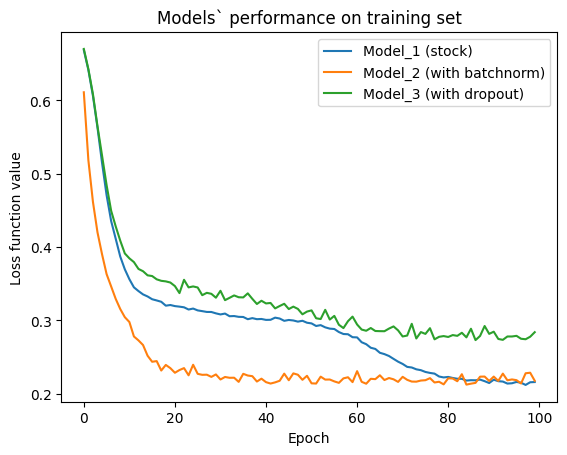

In [23]:
batch_size = 200
n_epochs = 100
loss_function = nn.BCELoss().to(device)
optimizer = 'adam'
learning_rate = 0.005

training_results = pd.DataFrame(columns=['Model_1 loss', 'Model_2 loss', 'Model_3 loss'])
training_results.index.name = 'Epoch'

print('--- Training Model_1 ---')
epoch_loss = training_loop(model_1, train_set, 
                           batch_size=batch_size, 
                           loss=loss_function, 
                           optimizer_=optimizer, 
                           learning_rate=learning_rate, 
                           n_epochs=n_epochs,
                           print_epochs=False)

plt.plot(epoch_loss, label='Model_1 (stock)')
training_results['Model_1 loss'] = epoch_loss


print('\n--- Training Model_2 ---')
epoch_loss = training_loop(model_2, train_set, 
                           batch_size=batch_size, 
                           loss=loss_function, 
                           optimizer_=optimizer, 
                           learning_rate=learning_rate, 
                           n_epochs=n_epochs,
                           print_epochs=False)

plt.plot(epoch_loss, label='Model_2 (with batchnorm)')
training_results['Model_2 loss'] = epoch_loss

print('\n--- Training Model_3 ---')
epoch_loss = training_loop(model_3, train_set, 
                           batch_size=batch_size, 
                           loss=loss_function, 
                           optimizer_=optimizer, 
                           learning_rate=learning_rate, 
                           n_epochs=n_epochs,
                           print_epochs=False)

plt.plot(epoch_loss, label='Model_3 (with dropout)')

training_results.index = [i for i in range(1, n_epochs+1)]
training_results['Model_3 loss'] = epoch_loss


print('\n', training_results)


plt.legend()
plt.title('Models` performance on training set')
plt.xlabel("Epoch")
plt.ylabel("Loss function value")
plt.show()

### Model evaluation on the test set

In [51]:
def evaluate_model(model, X_test, model_name='Model'):
    with torch.no_grad():
        y_pred = model(X_test.to(device)).sigmoid().detach()#.numpy().flatten()
        y_pred = (y_pred > 0.5).cpu().numpy().flatten().astype(int)
        
        sns.scatterplot(
            x=X_test[:, 0], y=X_test[:, 1], hue=y_pred, marker="o", s=25, edgecolor="k", legend=True
        ).set_title(f"{model_name} predictions")
        plt.show()

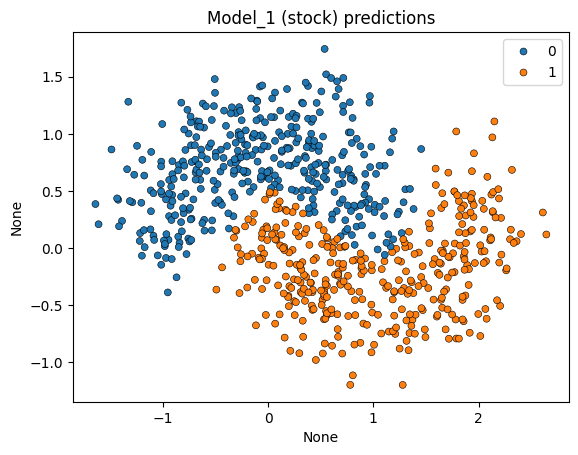

In [52]:
evaluate_model(model_1, test_set.features, model_name='Model_1 (stock)')

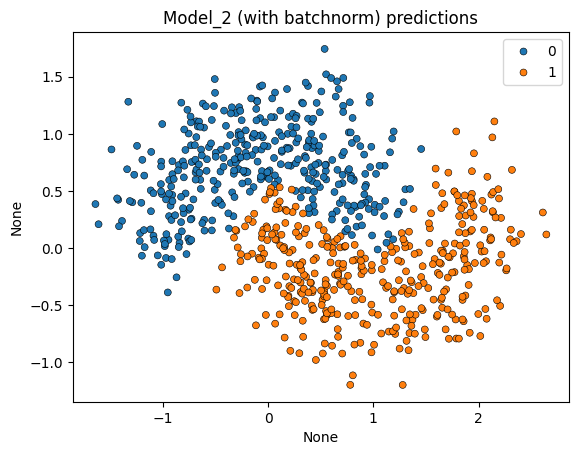

In [53]:
evaluate_model(model_2, test_set.features, model_name='Model_2 (with batchnorm)')

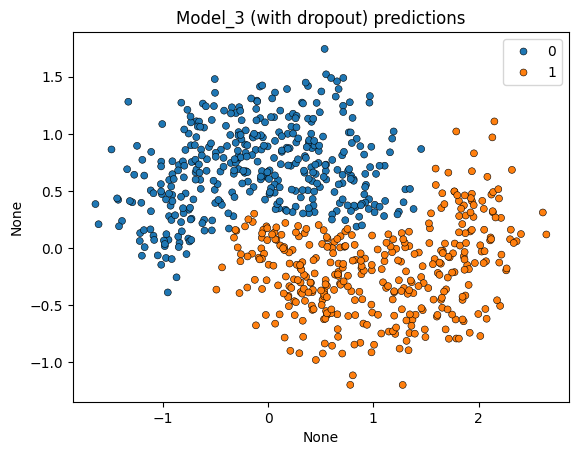

In [54]:
evaluate_model(model_3, test_set.features, model_name='Model_3 (with dropout)')